# Signals Analysis

In [39]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [40]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

In [41]:
%%capture
!summarize_logs.py atac ./qc_atac ./tag_directories_atac/*/
!summarize_logs.py rna ./qc_rna ./tag_directories_rna/*/
!summarize_logs.py gro ./qc_gro ./tag_directories_gro/*/
!summarize_logs.py gro ./qc_5gro ./tag_directories_g5ro/*/




In [42]:
summary_atac_frame = pd.read_csv('./qc_atac/mapping_stats.tsv', sep='\t')
summary_atac_frame['genome'] = 'mm10'
sample_names = summary_atac_frame['sample'].values
summary_atac_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_atac_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_atac_frame['treatment'] = [x.split('_')[3] for x in sample_names]



## C57Bl6 ATAC-seq

### Mapping Quality Control

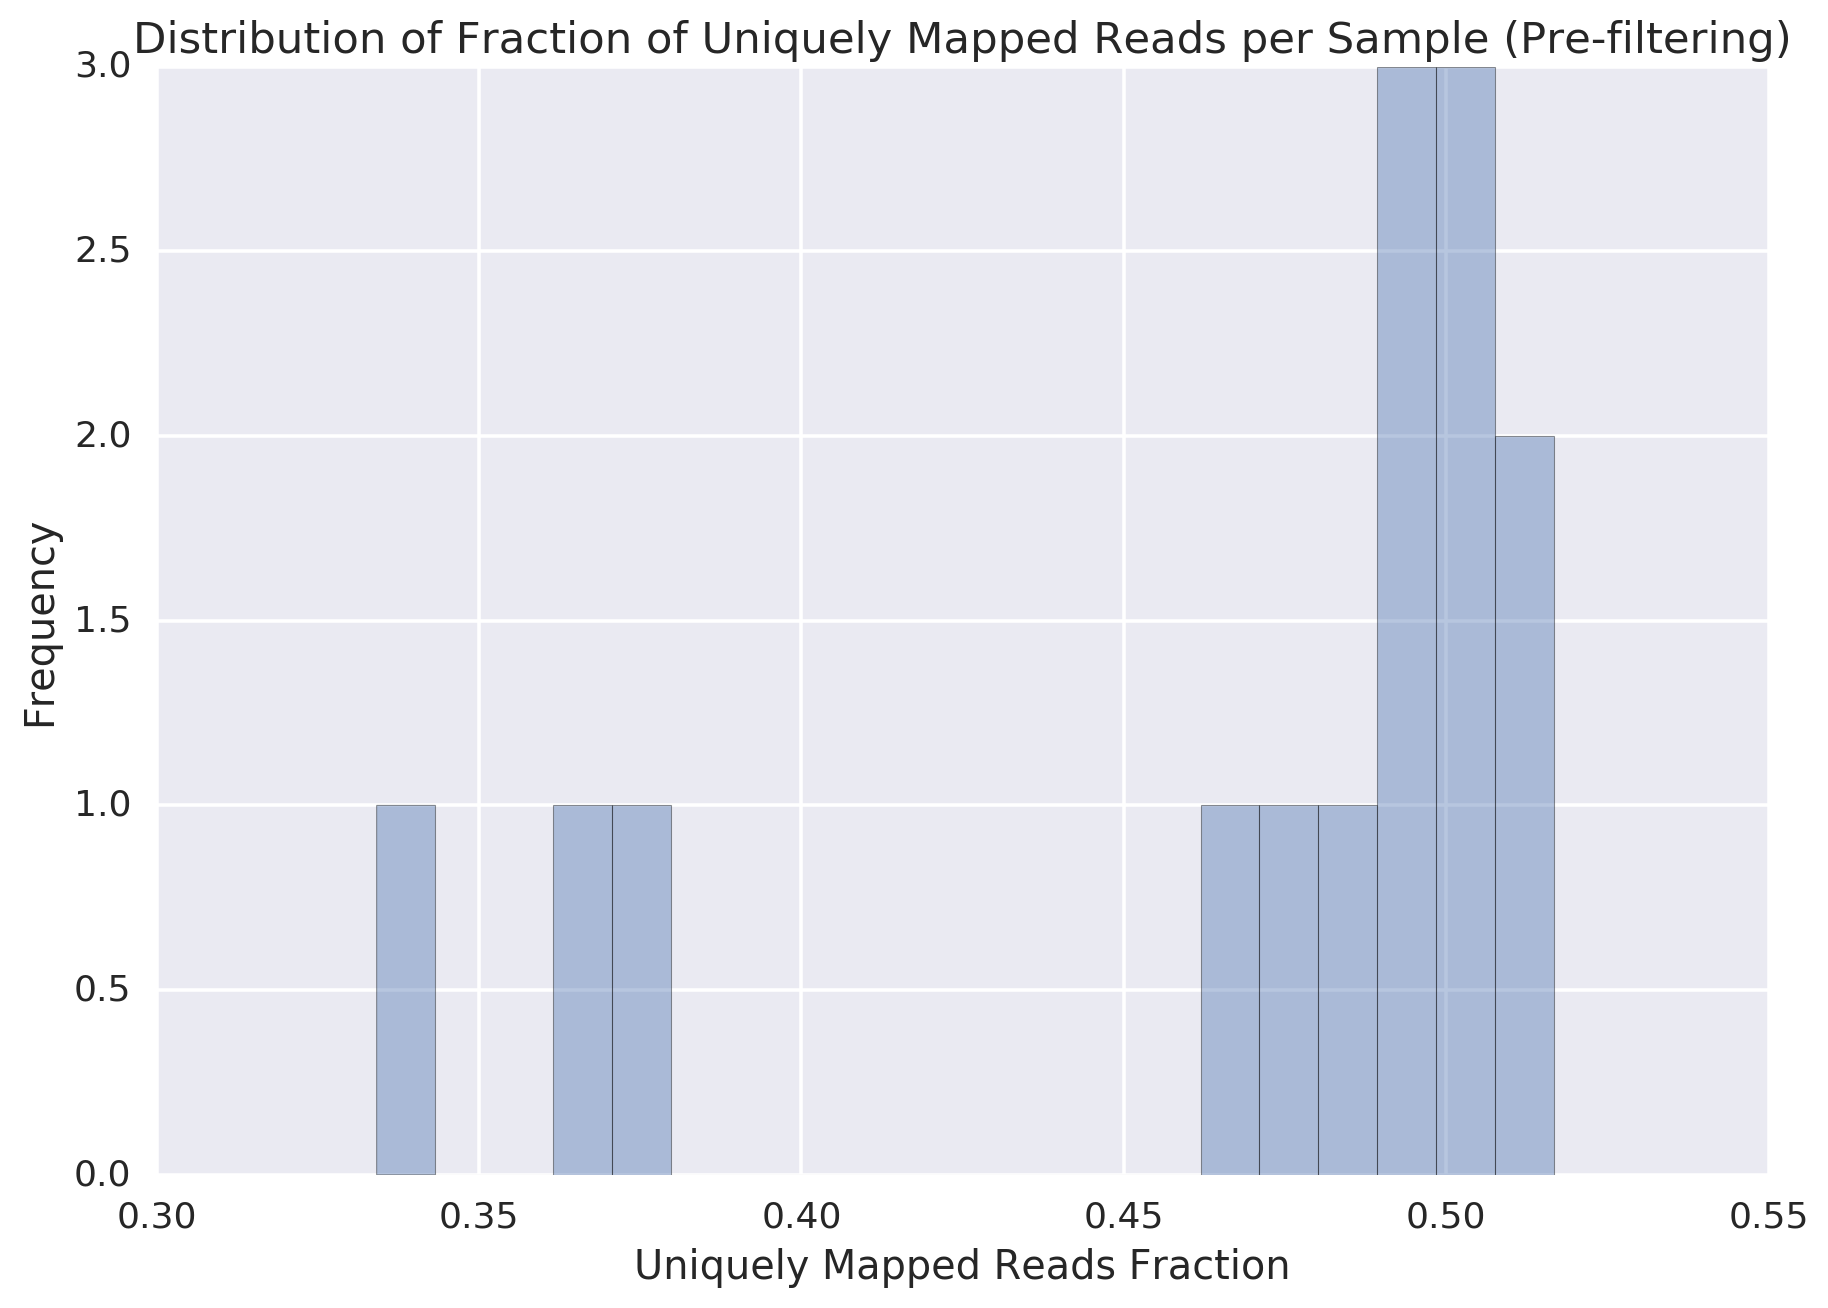

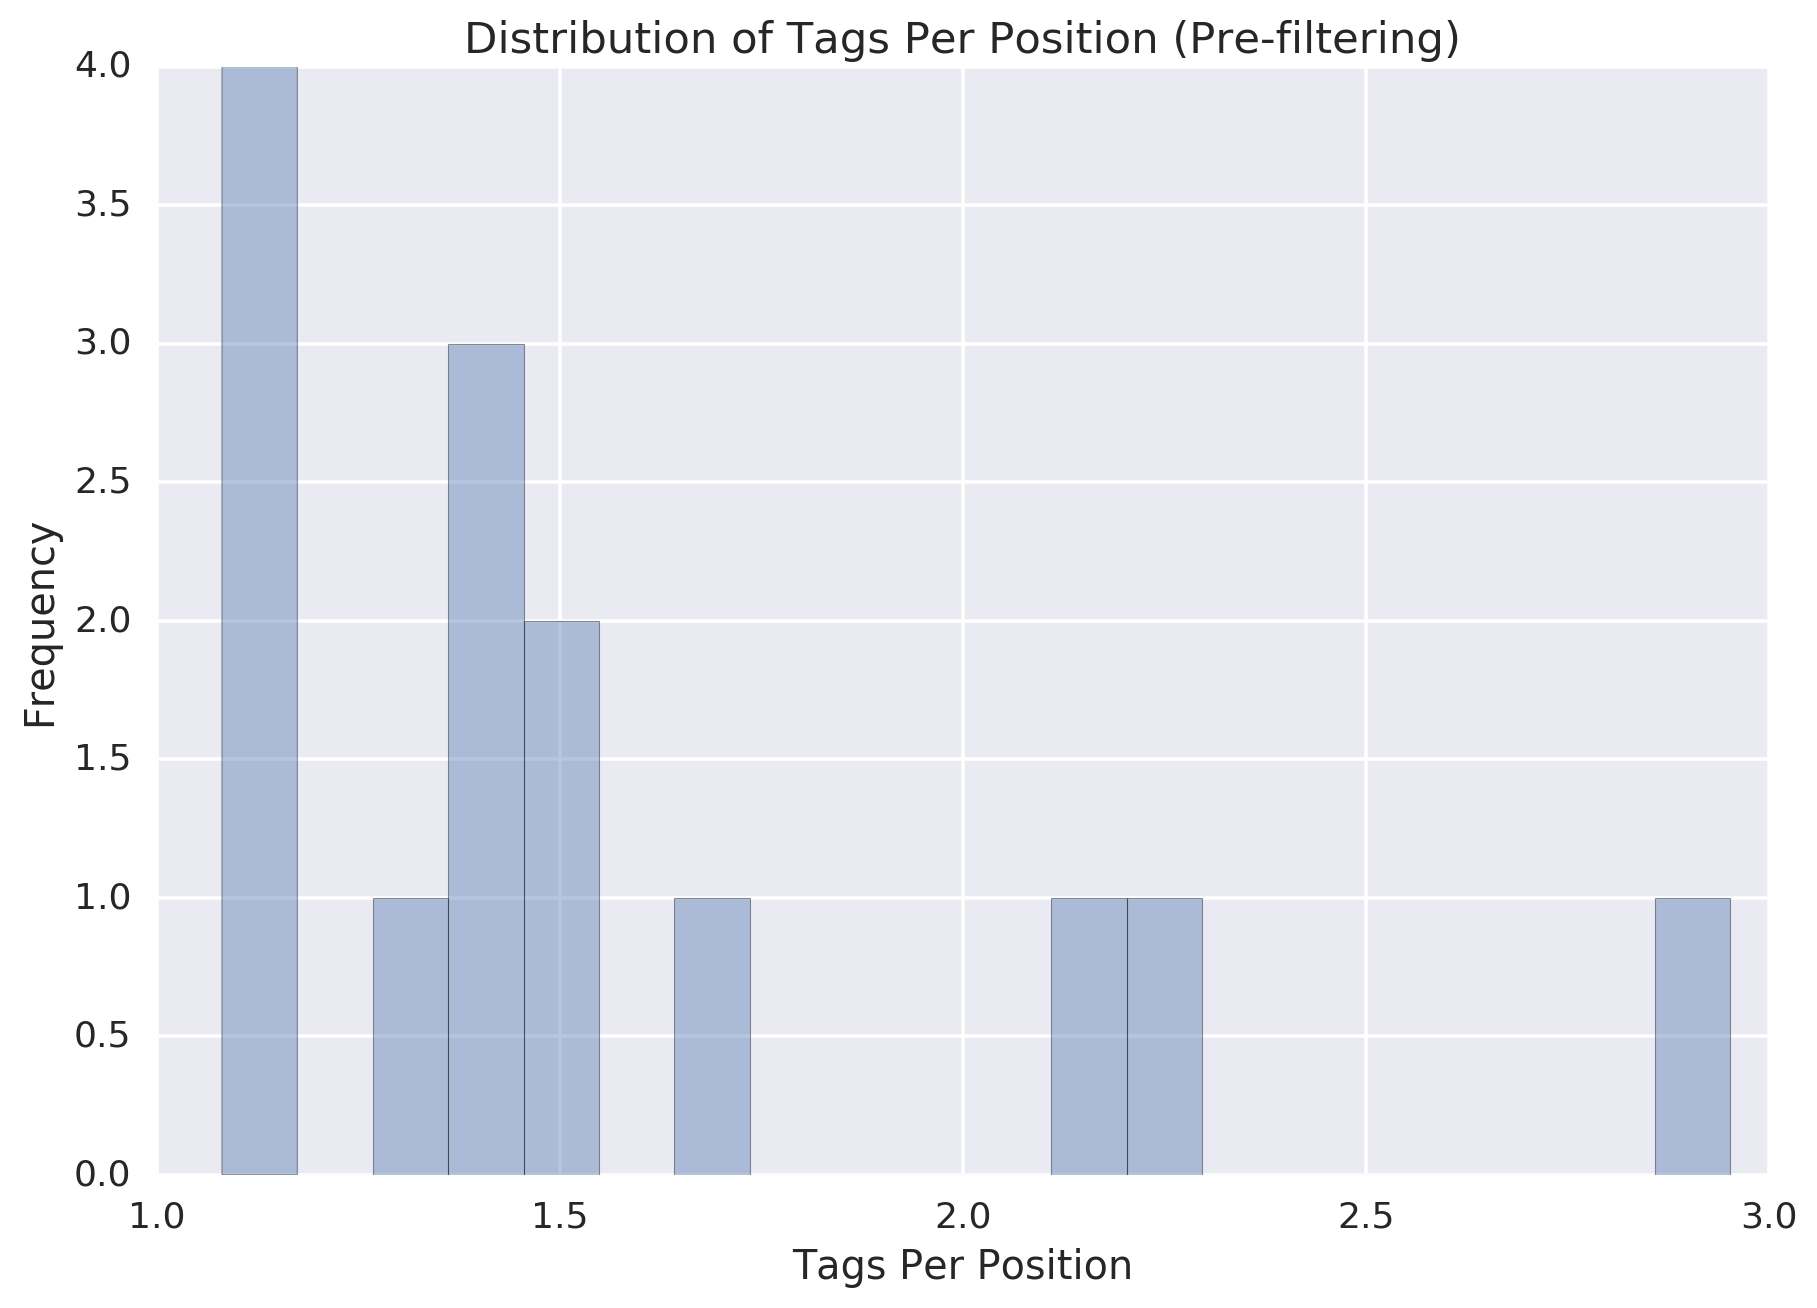

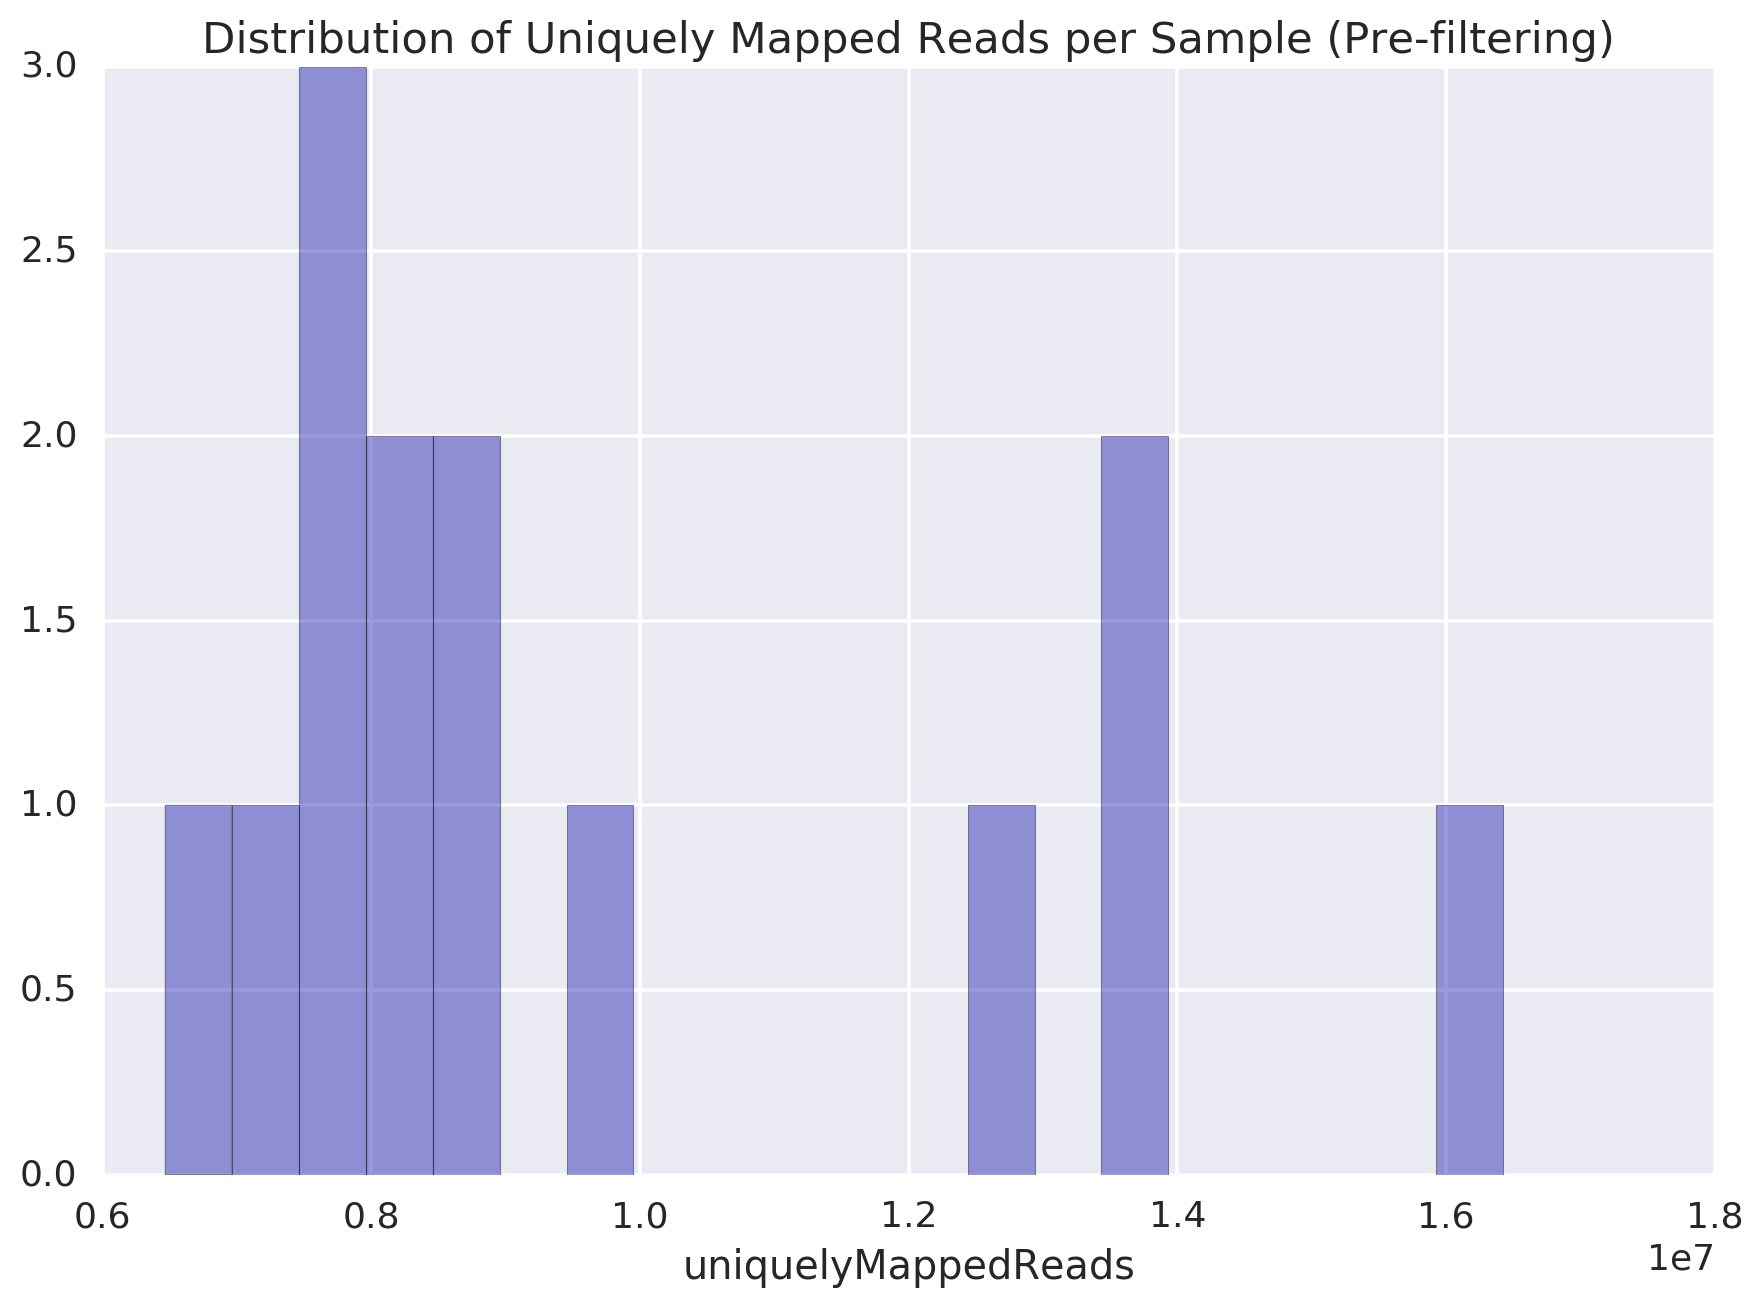

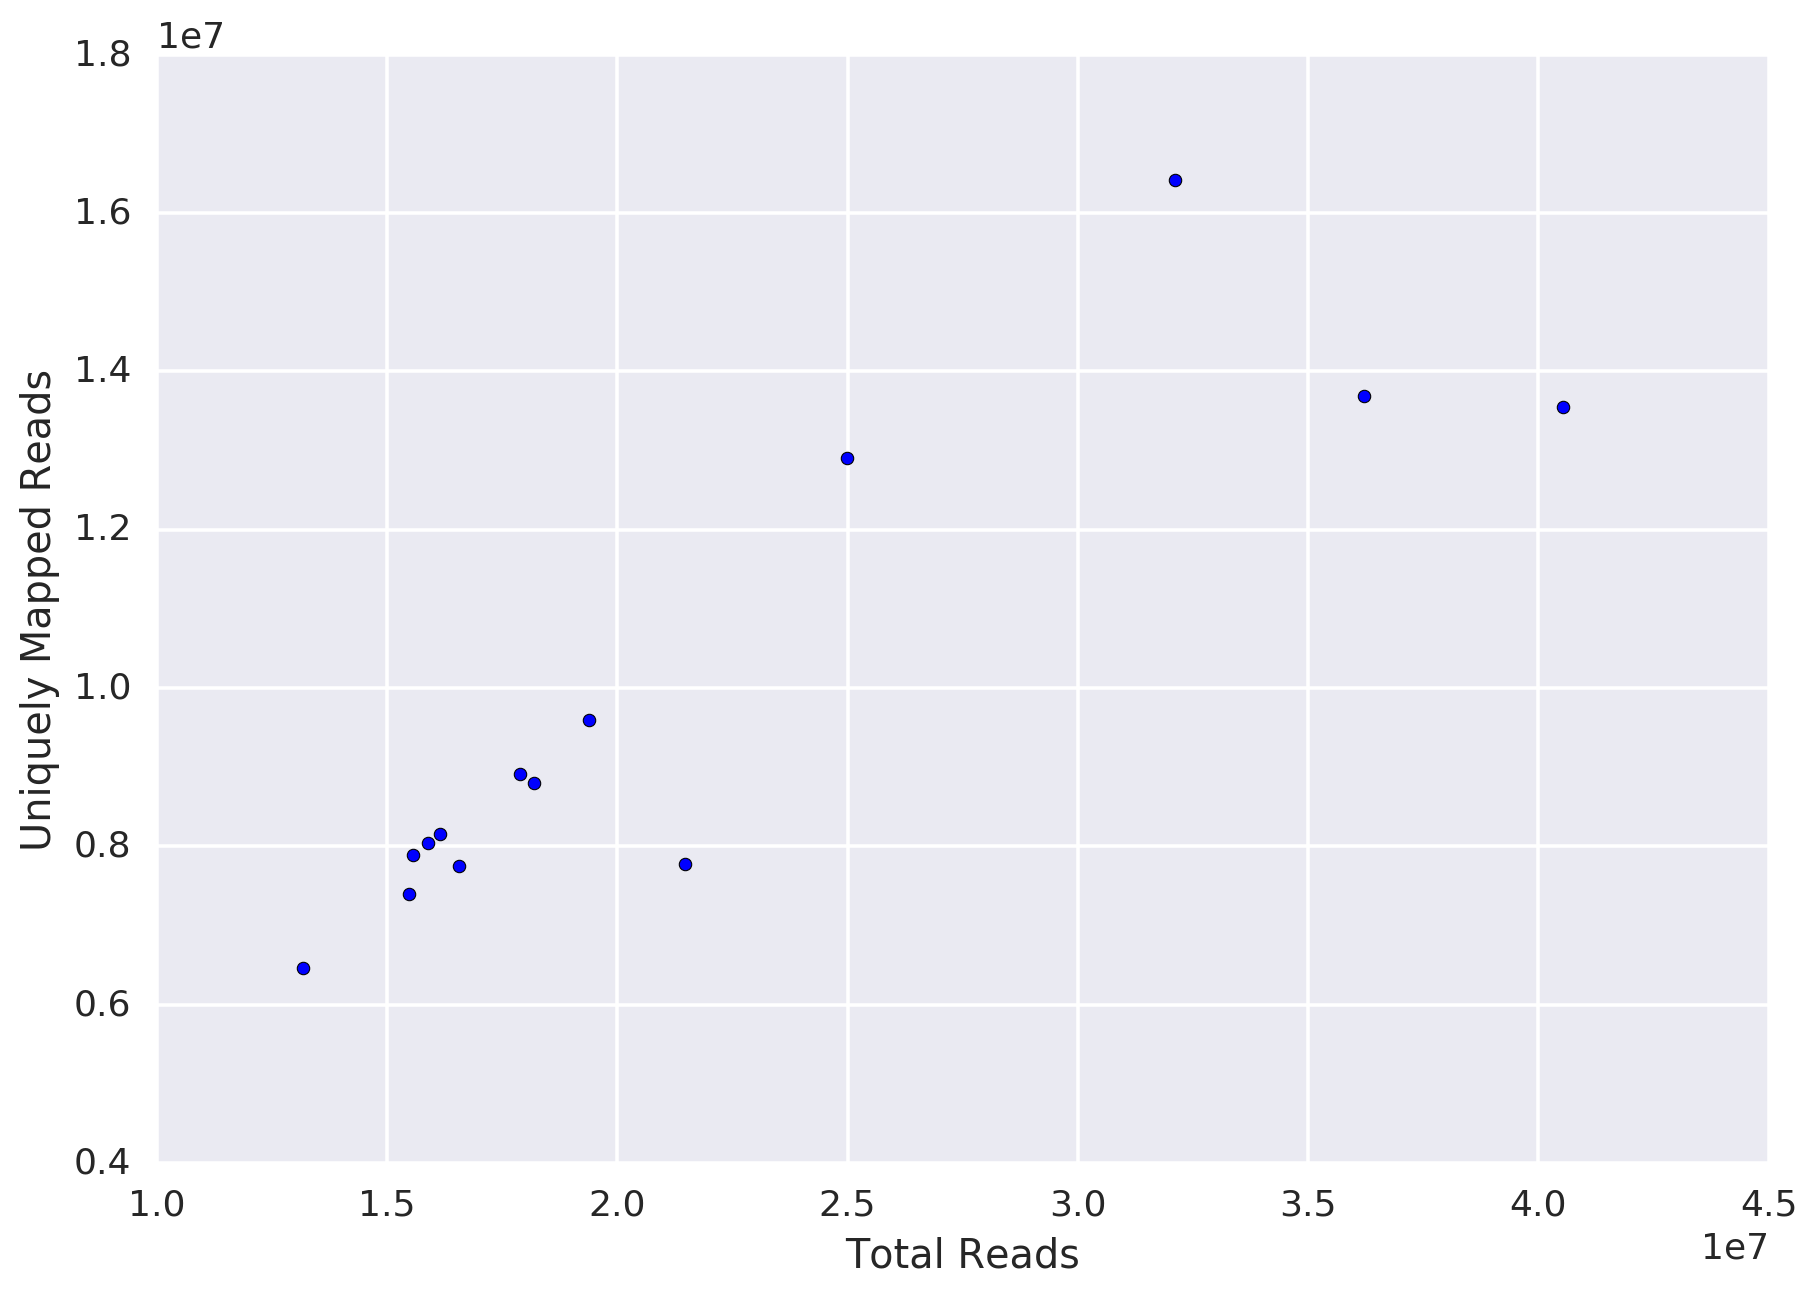

In [43]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_atac_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_atac_frame['clonality'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_atac_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.show()


plt.scatter(x = summary_atac_frame['totalReads'].astype(float).values, y=summary_atac_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Total Reads')
plt.ylabel('Uniquely Mapped Reads')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [44]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 0

filtered_summary_atac_frame = summary_atac_frame.copy()
# # filter on fraction of mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['mappedFraction'] >= mappedFractionThreshold]
# # filter on total mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_atac_frame['sample'].values if not x in filtered_summary_atac_frame['sample'].values]
discarded_summary_atac_frame = summary_atac_frame[summary_atac_frame['sample'].isin(discardedSampleNames)]
print("Number of Samples:", summary_atac_frame.shape[0])
print("Number of discarded samples:",discarded_summary_atac_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_atac_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_atac_frame['strain'] 
                            + '_' + filtered_summary_atac_frame['treatment'] 
                            + '_' + filtered_summary_atac_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_atac_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_atac_frame['sample'].values,
                                       filtered_summary_atac_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_atac_frame['simplifiedName'].values,
                                       filtered_summary_atac_frame['sample'].values))



Number of Samples: 14
Number of discarded samples: 0
Number of Samples remaining after filtering: 14


### Peak Calling

In [45]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')
scriptFile2 = open('./peakCalling_homer.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in filtered_summary_atac_frame['sample'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 150  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + atacTagDirPath + '/' + tagDir
                 + ' -style factor -size 150 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [46]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

	Fragment Length = 78
	Total Tags = 3662432.0
	Tags per bp = 0.001831
	Max tags per bp set automatically to 1.0
	Fragment Length = 65
	Total Tags = 2749270.0
	Tags per bp = 0.001375
	Max tags per bp set automatically to 1.0
	Fragment Length = 78
	Total Tags = 3522168.0
	Tags per bp = 0.001761
	Max tags per bp set automatically to 1.0
	Finding peaks of size 150, no closer than 300
	Finding peaks of size 150, no closer than 300
	Finding peaks of size 150, no closer than 300
	Fragment Length = 87
	Total Tags = 4845257.0
	Tags per bp = 0.002423
	Max tags per bp set automatically to 1.0
	Fragment Length = 79
	Finding peaks of size 150, no closer than 300
	Total Tags = 3870993.0
	Tags per bp = 0.001935
	Max tags per bp set automatically to 1.0
	Fragment Length = 80
	Total Tags = 2602215.0
	Tags per bp = 0.001301
	Fragment Length = 67
	Max tags per bp set automatically to 1.0
	Total Tags = 5890799.0
	Tags per bp = 0.002945
	Max tags per bp set automatically to 1.0
	Fragment Length = 81
	Total

### Run IDR

In [47]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
for treatment in sorted(set(filtered_summary_atac_frame['treatment'])):
    samples = filtered_summary_atac_frame[filtered_summary_atac_frame['treatment'] == treatment]['simplifiedName'].values
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.05"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [48]:
%%bash
# rm ./ap1_idr/*
chmod a+x ./scratch/*
bash ./run_idr.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_tgfbeta-1h_sd338_1_peaks.tsv, /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_tgfbeta-1h_sd339_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//c57bl6_tgfbeta-1h_sd338_1_peaks.narrowPeak ./atac_idr//c57bl6_tgfbeta-1h_sd339_1_peaks.narrowPeak --output-file ./atac_idr//c57bl6_tgfbeta-1h_sd338_1_peaks_c57bl6_tgfbeta-1h_sd339_1_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_r848-1h_sd344_1_peaks.tsv, /home/jtao/analysis/signals_analysis//atac_peak_files/c57bl6_r848-1h_sd345_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR

chmod: cannot access ‘./scratch/*’: No such file or directory
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.46 1.16 0.76 0.58]
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.2-py3.5-linux-x86_64.egg/idr/idr.py:415: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if localIDRs == None or IDRs == None:
Number of reported peaks - 11493/30892 (37.2%)

Number of peaks passing IDR cutoff of 0.05 - 11493/30892 (37.2%)

/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: FutureWarning: sort(....) is deprecated, use sort_index(.....)


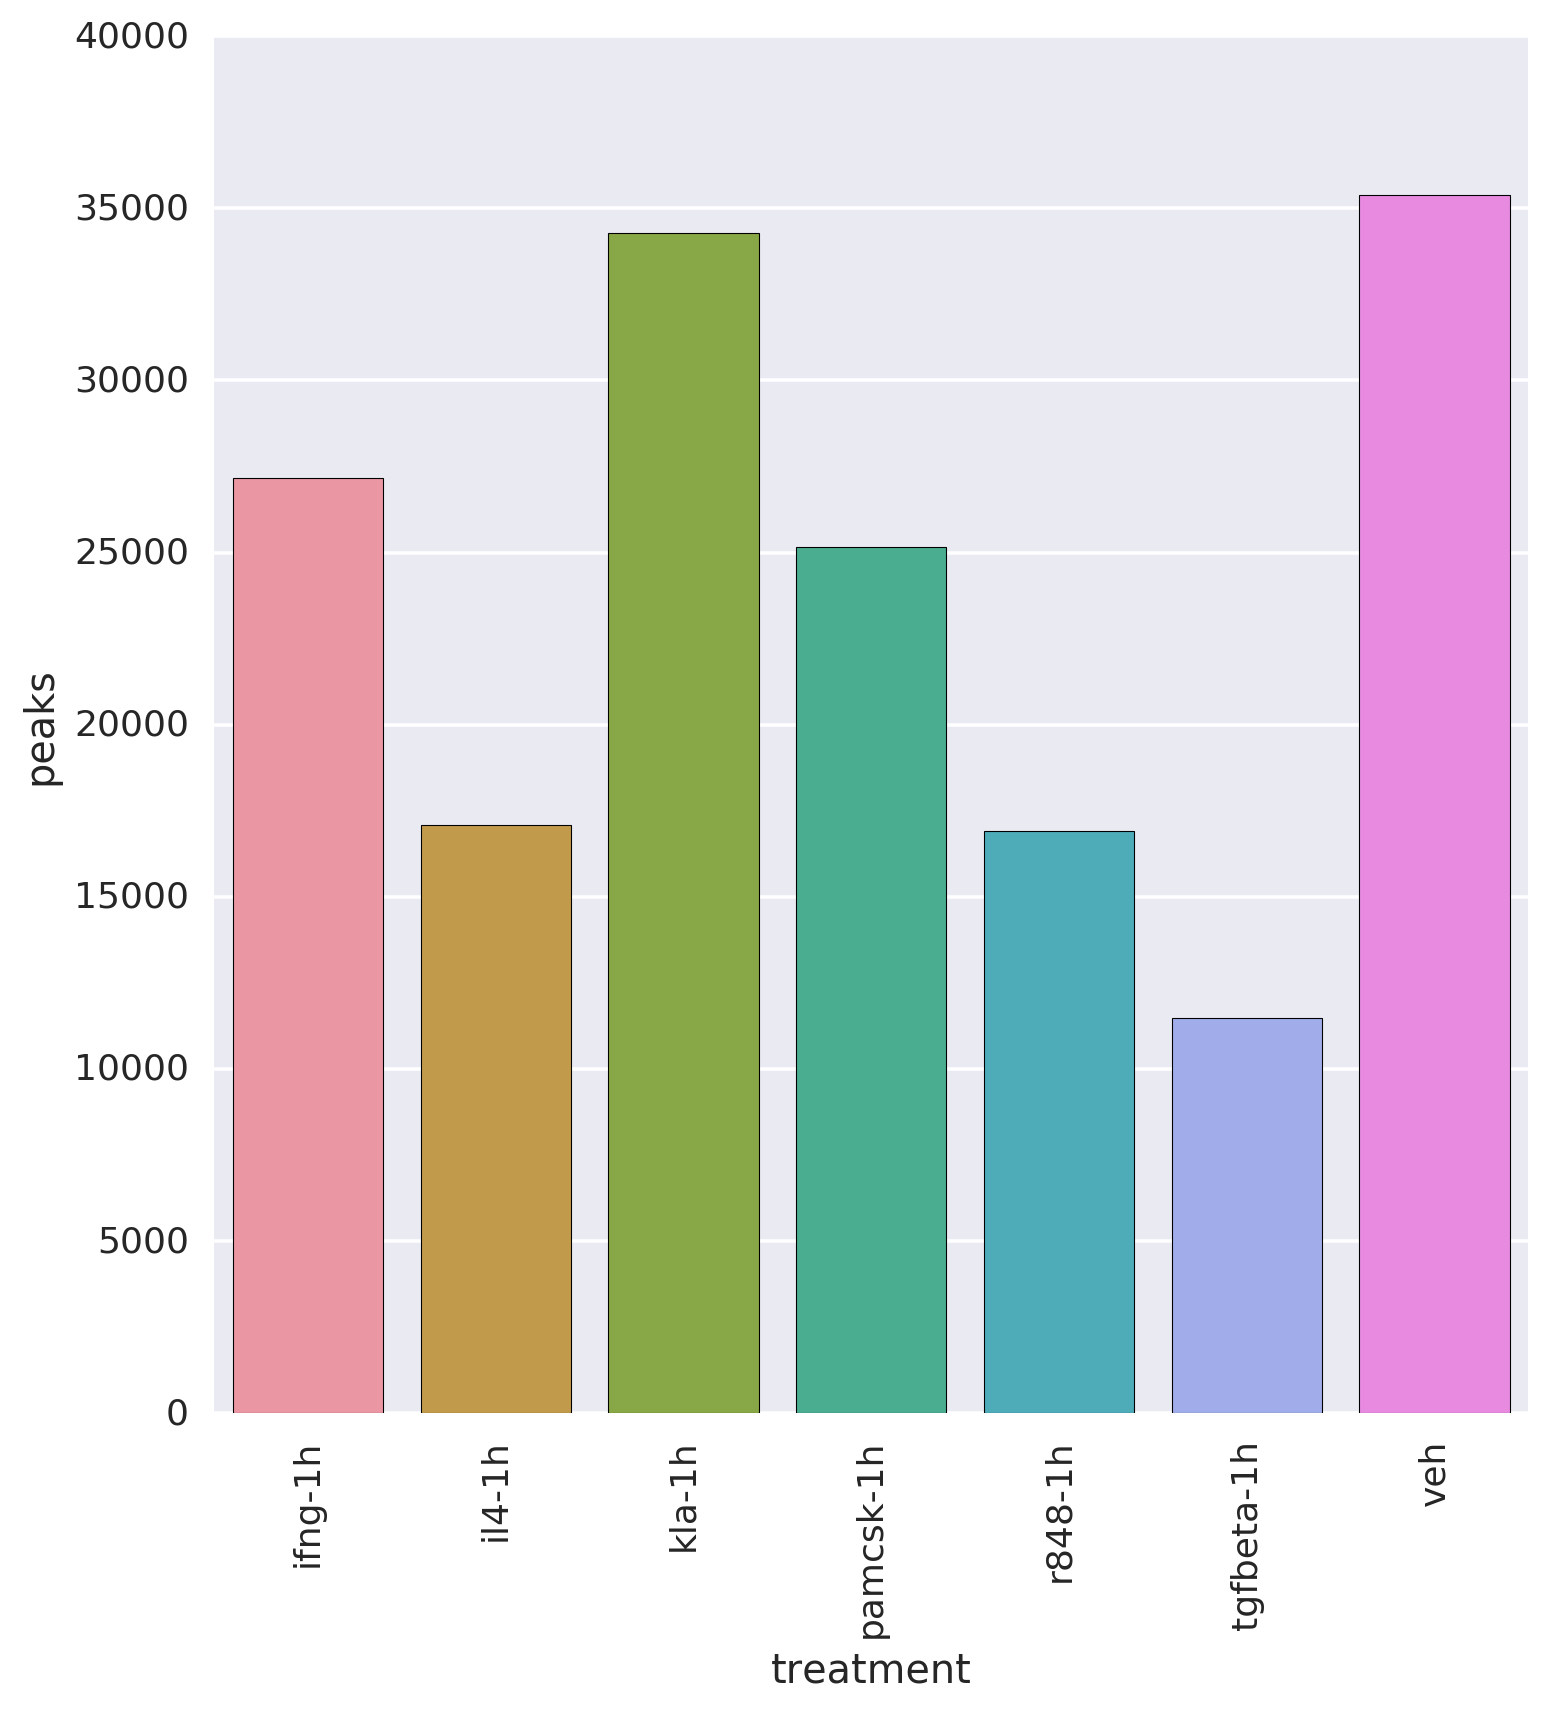

In [49]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:3])
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
    tokens = treatment.split('_')
    strains.append(tokens[0])
    treatments.append(tokens[1])
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['treatment'].values)])
idrPeak_frame = idrPeak_frame.sort()
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [50]:
outFile = open('./best_samples.tsv','w')
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[1]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    outFile.write('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key]),'\n']))
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()




c57bl6	ifng-1h	C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340	C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341	c57bl6_ifng-1h_sd340_1_peaks_c57bl6_ifng-1h_sd341_1_peaks_idr.tsv
c57bl6	il4-1h	C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336	C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337	c57bl6_il4-1h_sd336_1_peaks_c57bl6_il4-1h_sd337_1_peaks_idr.tsv
c57bl6	kla-1h	C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15	C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06	c57bl6_kla-1h_16-02-11-and-16-09-15_1_peaks_c57bl6_kla-1h_16-05-06_1_peaks_idr.tsv
c57bl6	pamcsk-1h	C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342	C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343	c57bl6_pamcsk-1h_sd342_1_peaks_c57bl6_pamcsk-1h_sd343_1_peaks_idr.tsv
c57bl6	r848-1h	C57Bl6_BMDM_ATAC_R848-1h_SD_SD344	C57Bl6_BMDM_ATAC_R848-1h_SD_SD345	c57bl6_r848-1h_sd344_1_peaks_c57bl6_r848-1h_sd345_1_peaks_idr.tsv
c57bl6	tgfbeta-1h	C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338	C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339	c57bl6_tgfbeta-1h_sd338_1_peaks_c57bl6_tgfbeta-1h_sd339_1_peaks_idr.tsv
c57bl6	veh	C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09

In [13]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(treatment_bestIDR_dict.keys()):
for key in treatment_bestIDR_dict.keys():
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_atac/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl signals_atac mm10 -norm 1e6 -force -d $tagDirString
# ! makeMultiWigHub.pl ap1_idr mm10 -force -normLength 150 -fragLength 150 -tbp 1 -d $tagDirString

makeMultiWigHub.pl signals_atac mm10 -norm 1e6 -fragLength 150 -normLength 150 -force -d ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344 ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345 ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15 ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06 ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342 ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06


## Merge Peak Files

In [51]:
target_peak_size = 75

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./atac_idr_peaks/'):
    current_peak_frame = pd.read_csv('./atac_idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [52]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [53]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 150
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -d ./tag_directories_atac/*/ > ./annotated_atac_peaks.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06/
	Peak/BED file con

In [58]:
! makeSummaryFile.py ./merged_atac_peaks_filtered_resized.tsv ./group_atac_summary.tsv ./resized_peak_files/*

Finished reading merged peak file...
Integrating scores for c57bl6_ifng-1h
Integrating scores for c57bl6_il4-1h
Integrating scores for c57bl6_kla-1h
Integrating scores for c57bl6_pamcsk-1h
Integrating scores for c57bl6_r848-1h
Integrating scores for c57bl6_tgfbeta-1h
Integrating scores for c57bl6_veh


In [61]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

## Calculate Differential ATAC-seq peaks

In [70]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d ./tag_directories_atac/*/ > ./annotated_atac_peaks_raw.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Will NOT normalize tag counts
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_

In [73]:
data

'PeakID (cmd=annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15/ ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06/)\tChr\tStart\tEnd\tStrand\tPeak Score\tFocus Ratio/Region Size\tAnno

In [77]:
with open('./annotated_atac_peaks_raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[19:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./annotated_atac_peaks_raw.tsv $condition_string -AvsA > edgeR_atac_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected annotatePeaks.pl file
	Output Stats IFNg-1h vs. IL4-1h:
		Total Genes: 54859
		Total Up-regulated in IL4-1h vs. IFNg-1h: 47 (0.086%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IL4-1h vs. IFNg-1h: 72 (0.131%) [log2fold<-1, FDR<0.05]
	Output Stats IFNg-1h vs. KLA-1h:
		Total Genes: 54859
		Total Up-regulated in KLA-1h vs. IFNg-1h: 8034 (14.645%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. IFNg-1h: 5979 (10.899%) [log2fold<-1, FDR<0.05]
	Output Stats IFNg-1h vs. PamCSK-1h:
		Total Genes: 54859
		Total Up-regulated in PamCSK-1h vs. IFNg-1h: 648 (1.181%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PamCSK-1h vs. IFNg-1h: 360 (0.656%) [log2fold<-1, FDR<0.05]
	Output Stats IFNg-1h vs. R848-1h:
		Total Genes: 54859
		Total Up-regulated in R848-1h vs. IFNg-1h: 395 (0.720%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in R84

## Calculate Motif Scores

In [59]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

rm: cannot remove ‘./peak_sequences/*’: No such file or directory


In [60]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_filtered_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_filtered_resized.bed
rm tmp


	Converted 54859 peaks total



In [62]:
!/gpfs/data01/glasslab/home/jtao/code/tba/extract_sequences.py ./merged_atac_peaks_filtered_resized.bed mm10 ./merged_atac_peaks_filtered_resized.fasta

reading genome mm10


### All Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_all_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

### Top Motif Scores

In [ ]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/calculate_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./top_motif_scores /gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/*motif 

# Call TSS using 5'GRO'

In [25]:
summary_gro_frame = pd.read_csv('./qc_gro/mapping_stats.tsv', sep='\t')
summary_gro_frame['genome'] = 'mm10'
sample_names = summary_gro_frame['sample'].values
summary_gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]

summary_5gro_frame = pd.read_csv('./qc_5gro/mapping_stats.tsv', sep='\t')
summary_5gro_frame['genome'] = 'mm10'
sample_names = summary_5gro_frame['sample'].values
summary_5gro_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_5gro_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_5gro_frame['treatment'] = [x.split('_')[3] for x in sample_names]


In [28]:
treatments = sorted(set(summary_5gro_frame['treatment'].values))

In [89]:
tag_dir_path_5gro = './tag_directories_5gro/'
tag_dir_path_gro = './tag_directories_gro/'
tss_path = './tss_scratch/'
tss_final_path = './tss/'

In [93]:
for treatment in treatments:
    print(treatment)
    samples_gro = summary_gro_frame[summary_gro_frame['treatment'] == treatment]['sample'].values
    samples_5gro = summary_5gro_frame[summary_5gro_frame['treatment'] == treatment]['sample'].values
    # call TSS using both GRO as input for each 5GRO experiment
    counter_5gro = 1
    replicate_list = []
    for samp_5gro in samples_5gro:
        command = 'findPeaks ' + tag_dir_path_5gro + samp_5gro + ' -norm 1e6 -style tss' 
        counter_gro = 1
        tss_path_list = []
        for samp_gro in samples_gro:
            current_command = command + ' -i '+ tag_dir_path_gro + samp_gro + ' -o '
            current_tss_path = tss_path + treatment + '_rep' + str(counter_5gro) + '_input' + str(counter_gro) + '_tss.tsv'
            current_command = current_command + ' ' + current_tss_path
            counter_gro += 1
            tss_path_list.append(current_tss_path)
            if not os.path.isfile(current_tss_path):
                os.system(current_command)
        # merge tss called using different inputs together
        merge_command = 'mergePeaks ' + ' '.join(tss_path_list) + ' -prefix ' + tss_path + treatment
        os.system(merge_command)
        # rename intersection file
        intersection_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in tss_path_list])
        renamed_intersection_path = tss_path + treatment + '_rep'+str(counter_5gro) + '_tss.tsv'
        os.system('cp ' + tss_path+  intersection_path + ' '+ renamed_intersection_path)
        replicate_list.append(renamed_intersection_path)
        counter_5gro += 1
    # merge replicates
    merge_command = 'mergePeaks ' + ' '.join(replicate_list) + ' -prefix ' + tss_path + treatment
    os.system(merge_command)
    # rename merged replicate
    merged_replicate_path = treatment + '_.' + '_.'.join([x.replace('./','_').replace('/','_') for x in replicate_list])
    renamed_merged_replicate_path = tss_final_path + treatment + '_tss.tsv'
    os.system('mv ' + tss_path+  merged_replicate_path + ' '+ renamed_merged_replicate_path)


KLA-1h
Veh


## Calculating Differentially Expressed Genes

In [65]:
tag_dirs = sorted(os.listdir('./tag_directories_rna/'))
treated_dirs = ' '.join(['./tag_directories_rna/' + x for x in tag_dirs if not '_Veh-1h_' in x])
veh_dirs = ' '.join(['./tag_directories_rna/' +x for x in tag_dirs if  '_Veh-1h_' in x])

In [66]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d $veh_dirs $treated_dirs > raw.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09_20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_pa

In [67]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d $veh_dirs $treated_dirs > rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Veh-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IFNg-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_IL4-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_KLA-1h_Newton-Josh_14-03-01-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_R848-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_Tgfb-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09-20-rep2
		./tag_directories_rna/C57Bl6_BMDM_RNA_VehTgfB-1h_GJF_16-09_20-rep1
		./tag_directories_rna/C57Bl6_BMDM_RNA_pa

In [68]:
with open('./raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[8:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./raw.tsv $condition_string -AvsA > edgeR_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Veh-1h vs. IFNg-1h:
		Total Genes: 24453
		Total Up-regulated in IFNg-1h vs. Veh-1h: 63 (0.258%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IFNg-1h vs. Veh-1h: 142 (0.581%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. IL4-1h:
		Total Genes: 24453
		Total Up-regulated in IL4-1h vs. Veh-1h: 28 (0.115%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IL4-1h vs. Veh-1h: 39 (0.159%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. KLA-1h:
		Total Genes: 24453
		Total Up-regulated in KLA-1h vs. Veh-1h: 617 (2.523%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh-1h: 324 (1.325%) [log2fold<-1, FDR<0.05]
	Output Stats Veh-1h vs. R848-1h:
		Total Genes: 24453
		Total Up-regulated in R848-1h vs. Veh-1h: 5 (0.020%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in R848-1h vs. Veh-1h: 38 (0.